In [4]:
# Import libs
import random
import matplotlib.pyplot as plt
import numpy as np

In [113]:
# Base bandit class
class bandit():
    def __init__(self, q_opt, Q_init=0):
        self.q_opt = q_opt
        self.Q_value =  
        self.n = 0
    
    def update_q_opt(self, new_value):
        self.q_opt += new_value    
    
    def get_q_opt(self):
        return self.q_opt
    
    def get_Q_value(self):
        return self.Q_value
    
    def get_reward(self):
        return random.gauss(self.q_opt, 1)
    
    def update_Q_value(self, reward):
        self.n += 1
        self.Q_value += (reward - self.Q_value)/self.n
        #if noise:
        #    self.q_opt  = self.q_opt + random.gauss(0, 0.01)
            
    def update_Q_value_constant_step(self, reward, alpha=0.1):
        self.n += 1
        self.Q_value += (alpha * (reward - self.Q_value))
        #if noise:
        #    self.q_opt = self.q_opt + random.gauss(0, 0.01)

In [114]:
# Multi-armed bandit class
class multiArmedBandit():
    def __init__(self, mode=0, k=10):
        if mode == 1:
            #print("using gauss")
            val = random.gauss(0, 1)
            self.bandits = [bandit(val) for i in range(k)]
        elif mode == 2:
            #print("using uniform")
            val = 5
            self.bandits = [bandit(random.gauss(0, 1), Q_init=val) for i in range(k)]
        else:
            self.bandits = [bandit(random.gauss(0, 1)) for i in range(k)]
            
        self.default_q_opts = self.get_q_opts()
        self.default_Q_values = self.get_Q_values()
    
    def restore_defaults(self):
        for i, bandit in enumerate(self.bandits):
            bandit.q_opt = self.default_q_opts[i]
            bandit.Q_value = self.default_Q_values[i]
    
    def get_best_action(self):
        return np.argmax(np.asarray(self.get_q_opts()))
    
    def get_q_opts(self):
        """
        Return a copy list of optimal q values for all bandits.
        """
        temp = list()
        for bandit in self.bandits:
            temp.append(bandit.get_q_opt())
            
        return temp.copy()
    
    def get_Q_values(self):
        """
        Return a copy list of current Q values for all bandits.
        """
        temp = list()
        for bandit in self.bandits:
            temp.append(bandit.get_Q_value())
        
        return temp.copy()
    
    def add_noise(self):
        """
        Add gaussian noise to a bandit
        """
        for bandit in self.bandits:
            bandit.update_q_opt(random.gauss(0, 0.01))
            
    def get_UCB_con(self, confidence, steps):
        """
        UCB added term
        """
        temp = list()
        for bandit in self.bandits:
            if bandit.n==0:
                temp.append(confidence * 1e8)
            else:
                temp.append(confidence * np.sqrt((np.log(steps+1-bandit.n))/bandit.n))
            
        return temp.copy()
    
    def epsilon_greedy_action(self, epsilon):
        p = random.random()
        if p<=epsilon:
            return random.randint(0, 9)
        else:
            return np.argmax(np.asarray(self.get_Q_values()))
        
    def UCB_action(self, confidence, steps):
        """
        Return UCB action
        """
        return np.argmax(np.asarray(self.get_Q_values()) + np.asarray(self.get_UCB_con(confidence, steps)))

In [84]:
def exp(runs=2000, steps=1000):
    #plt.figure(figsize=(20, 15))
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
    epsilons = [0, 0.01, 0.1]
    for epsilon in epsilons:
        rewards = np.zeros((runs, steps))
        best_actions = np.zeros((runs, steps))
        for run in range(runs):
            trial = multiArmedBandit()

            for step in range(steps):
                action = trial.epsilon_greedy_action(epsilon)
                reward = trial.bandits[action].get_reward()
                trial.bandits[action].update_Q_value(reward)
                rewards[run, step] = reward
                
                if action==trial.get_best_action():
                    best_actions[run, step] = 1

        avg_rewards = rewards.mean(axis=0)
        avg_actions = best_actions.mean(axis=0)
        ax[0].plot(range(1000), avg_rewards, label='epsilon: '+str(epsilon))
        ax[1].plot(range(1000), avg_actions, label='epsilon: '+str(epsilon))
        #plt.legend(['epsilon: '+str(epsilon)])

    ax[0].set(xlabel = 'Steps')
    ax[0].set(ylabel = 'Average Rewards')
    #ax[0].legend(loc='lower right')
    ax[1].set(xlabel = 'Steps')
    ax[1].set(ylabel = 'Optimal Action taken')
    plt.legend(loc='lower right')
    plt.show()

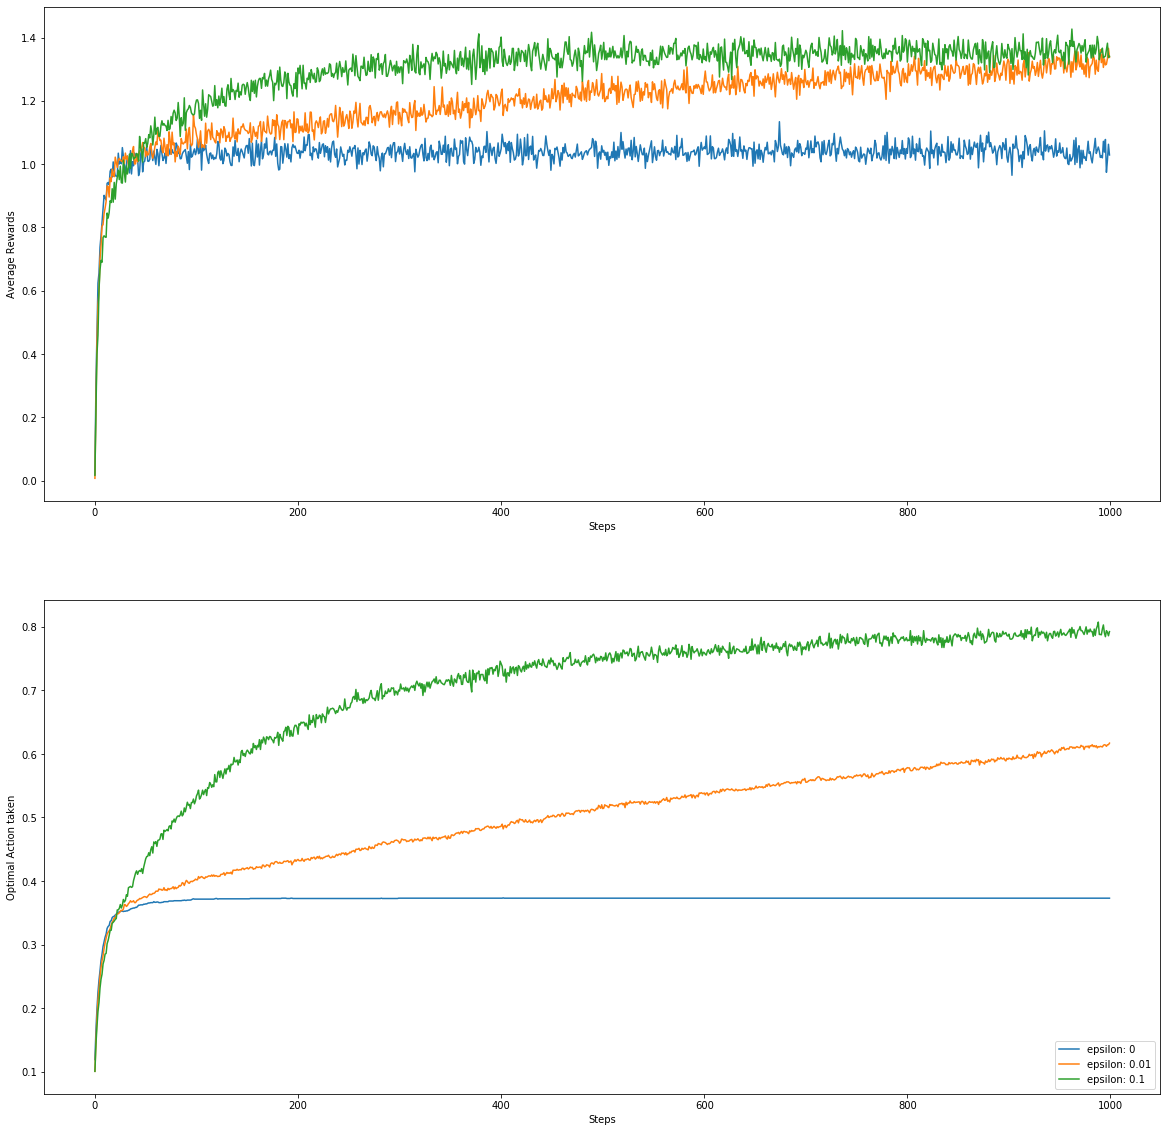

In [24]:
exp()

In [87]:
"""
Comparing Sample averaging and Constant step factor for non-stationary case
"""
def Q1_b(alpha=0.1, epsilon=0.1, runs=2000, steps=10000):
    #plt.figure(figsize=(20, 10))
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
    epsilons = [epsilon]
    for epsilon in epsilons:
        rewards = np.zeros((runs, steps))
        best_actions = np.zeros((runs, steps))
        for run in range(runs):
            trial = multiArmedBandit(mode="gauss")

            for step in range(steps):
                action = trial.epsilon_greedy_action(epsilon)
                reward = trial.bandits[action].get_reward()
                trial.bandits[action].update_Q_value(reward)
                trial.add_noise()
                rewards[run, step] = reward
                
                if action==trial.get_best_action():
                    best_actions[run, step] = 1

        avg_rewards = rewards.mean(axis=0)
        avg_actions = best_actions.mean(axis=0)
        ax[0].plot(range(10000), avg_rewards, label='epsilon: '+str(epsilon)+', Sample Mean')
        ax[1].plot(range(10000), avg_actions, label='epsilon: '+str(epsilon)+', Sample Mean')
        #plt.legend(['epsilon: '+str(epsilon)])
    
    epsilons = [epsilon]
    for epsilon in epsilons:
        rewards = np.zeros((runs, steps))
        best_actions = np.zeros((runs, steps))
        for run in range(runs):
            trial = multiArmedBandit(mode="gauss")
    
            for step in range(steps):
                action = trial.epsilon_greedy_action(epsilon)
                reward = trial.bandits[action].get_reward()
                trial.bandits[action].update_Q_value_constant_step(reward, alpha=0.1)
                rewards[run, step] = reward
                trial.add_noise()
                if action==trial.get_best_action():
                    best_actions[run, step] = 1
                    
        avg_rewards = rewards.mean(axis=0)
        avg_actions = best_actions.mean(axis=0)
        ax[0].plot(range(10000), avg_rewards, label='epsilon: '+str(epsilon)+', Constant Step')
        ax[1].plot(range(10000), avg_actions, label='epsilon: '+str(epsilon)+', Constant Step')
        #plt.legend(['epsilon: '+str(epsilon)])
        
    ax[0].set(xlabel = 'Steps')
    ax[0].set(ylabel = 'Average Rewards')
    #ax[0].legend(loc='lower right')
    ax[1].set(xlabel = 'Steps')
    ax[1].set(ylabel = 'Optimal Action taken')
    plt.legend(loc='lower right')
    plt.show()

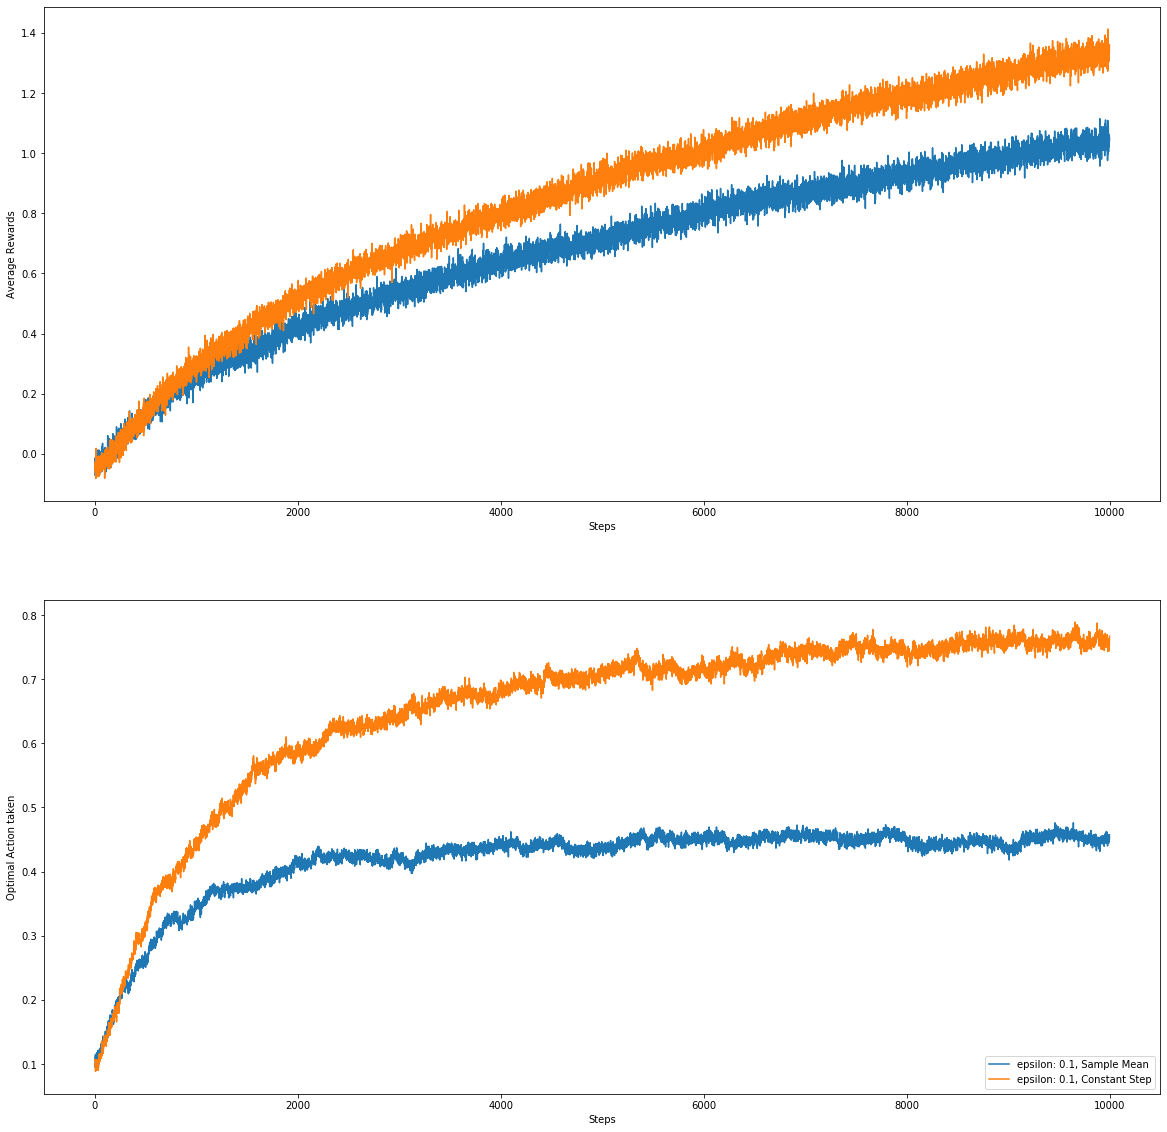

In [20]:
Q1_b()

In [88]:
"""
Comparison of Optimistic and Realistic epsilon greedy in stationary setting.
"""
def Q2_a(runs=2000, steps=1000, Q_init=5):
    #fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
    plt.figure(figsize=(20, 10))
    epsilon = 0
    epsilons = [epsilon]
    for epsilon in epsilons:
        #rewards = np.zeros((runs, steps))
        best_actions = np.zeros((runs, steps))
        for run in range(runs):
            trial = multiArmedBandit(mode=2)

            for step in range(steps):
                action = trial.epsilon_greedy_action(epsilon)
                reward = trial.bandits[action].get_reward()
                trial.bandits[action].update_Q_value_constant_step(reward, alpha=0.1)
                #rewards[run, step] = reward
                
                if action==trial.get_best_action():
                    best_actions[run, step] = 1

        #avg_rewards = rewards.mean(axis=0)
        avg_actions = best_actions.mean(axis=0)
        plt.plot(range(1000), avg_actions, label='epsilon: '+str(epsilon))
        #ax[1].plot(range(10000), avg_actions, label='epsilon: '+str(epsilon))
        #plt.legend(['epsilon: '+str(epsilon)])

    epsilon = 0.1
    epsilons = [epsilon]
    for epsilon in epsilons:
        #rewards = np.zeros((runs, steps))
        best_actions = np.zeros((runs, steps))
        for run in range(runs):
            trial = multiArmedBandit()

            for step in range(steps):
                action = trial.epsilon_greedy_action(epsilon)
                reward = trial.bandits[action].get_reward()
                trial.bandits[action].update_Q_value_constant_step(reward, alpha=0.1)
                #rewards[run, step] = reward
                
                if action==trial.get_best_action():
                    best_actions[run, step] = 1

        #avg_rewards = rewards.mean(axis=0)
        avg_actions = best_actions.mean(axis=0)
        plt.plot(range(1000), avg_actions, label='epsilon: '+str(epsilon))
        #ax[1].plot(range(10000), avg_actions, label='epsilon: '+str(epsilon))
        #plt.legend(['epsilon: '+str(epsilon)])
    #ax[0].set(xlabel = 'Steps')
    #ax[0].set(ylabel = 'Average Rewards')
    #ax[0].legend(loc='lower right')
    
    plt.xlabel('Steps')
    plt.ylabel('Optimal Action taken')
    plt.legend(loc='lower right')
    plt.show()

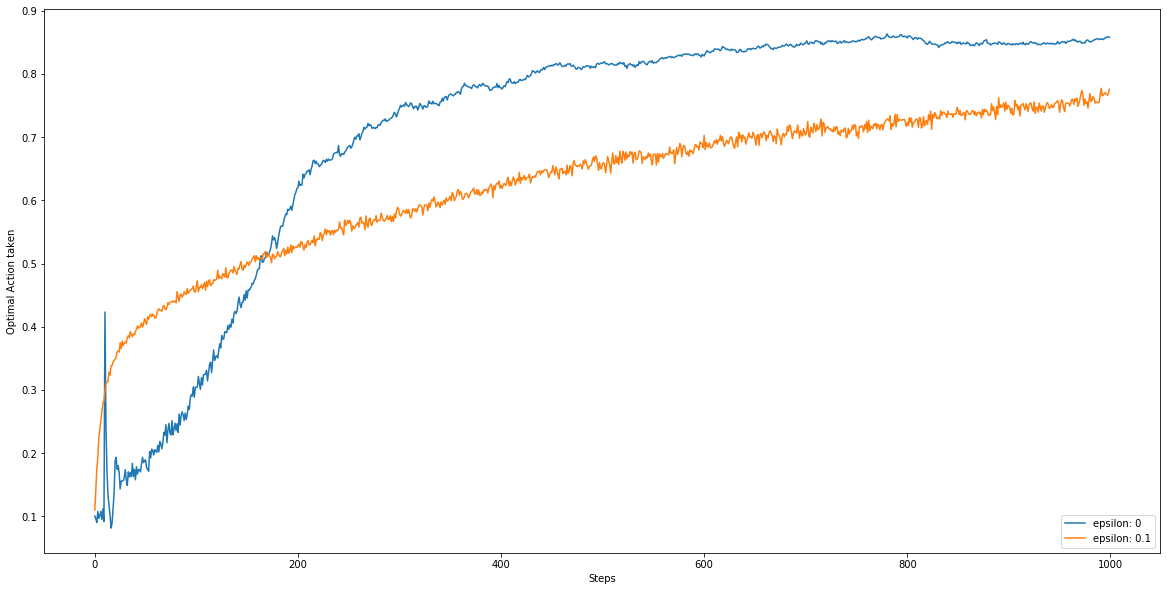

In [35]:
Q2_a()

In [127]:
"""
Comparison of Optimistic and Realistic epsilon greedy in non-stationary setting.
"""
def Q2_b(alpha=0.1, runs=2000, steps=10000):
    plt.figure(figsize=(20, 10))
    #fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
    epsilon = 0
    epsilons = [epsilon]
    for epsilon in epsilons:
        rewards = np.zeros((runs, steps))
        best_actions = np.zeros((runs, steps))
        
        for run in range(runs):
            trial = multiArmedBandit(mode=2)

            for step in range(steps):
                action = trial.epsilon_greedy_action(epsilon)
                reward = trial.bandits[action].get_reward()
                trial.bandits[action].update_Q_value_constant_step(reward, alpha=0.1)
                trial.add_noise()
                rewards[run, step] = reward
                
                if action==trial.get_best_action():
                    best_actions[run, step] = 1

        avg_rewards = rewards.mean(axis=0)
        avg_actions = best_actions.mean(axis=0)
        #ax[0].plot(range(10000), avg_rewards, label='epsilon: '+str(epsilon)+', Sample Mean')
        plt.plot(range(10000), avg_actions, label='Optimistic')
        #plt.legend(['epsilon: '+str(epsilon)])
    
    epsilon = 0.1
    epsilons = [epsilon]
    for epsilon in epsilons:
        rewards = np.zeros((runs, steps))
        best_actions = np.zeros((runs, steps))
        for run in range(runs):
            trial = multiArmedBandit(mode=1)
    
            for step in range(steps):
                action = trial.epsilon_greedy_action(epsilon)
                reward = trial.bandits[action].get_reward()
                trial.bandits[action].update_Q_value_constant_step(reward, alpha=0.1)
                rewards[run, step] = reward
                trial.add_noise()
                if action==trial.get_best_action():
                    best_actions[run, step] = 1
                    
        #avg_rewards = rewards.mean(axis=0)
        avg_actions = best_actions.mean(axis=0)
        #ax[0].plot(range(10000), avg_rewards, label='epsilon: '+str(epsilon)+', Constant Step')
        plt.plot(range(10000), avg_actions, label='Realistic')
        #plt.legend(['epsilon: '+str(epsilon)])
        
    plt.xlabel('Steps')
    plt.ylabel('Optimal Action taken')
    plt.legend(loc='lower right')
    plt.show()

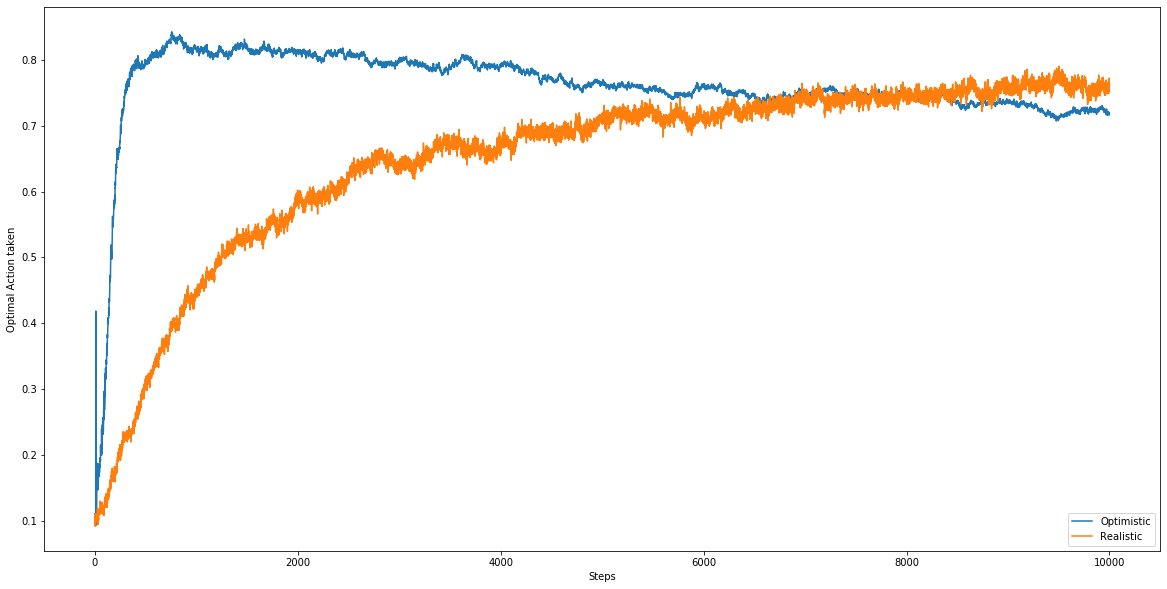

In [128]:
Q2_b()

In [145]:
"""
UCB compared with epsilon greedy in realistic and optimistic settings
for a stationary distribution
"""
def Q4_a(runs=2000, steps=1000):
    #plt.figure(figsize=(20, 10))
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
    # Realistic Greedy
    epsilon = 0.1
    epsilons = [epsilon]
    for epsilon in epsilons:
        rewards = np.zeros((runs, steps))
        best_actions = np.zeros((runs, steps))
        for run in range(runs):
            trial = multiArmedBandit()

            for step in range(steps):
                action = trial.epsilon_greedy_action(epsilon)
                reward = trial.bandits[action].get_reward()
                trial.bandits[action].update_Q_value(reward)
                rewards[run, step] = reward
                
                if action==trial.get_best_action():
                    best_actions[run, step] = 1

        avg_rewards = rewards.mean(axis=0)
        avg_actions = best_actions.mean(axis=0)
        ax[0].plot(range(1000), avg_rewards, label='Realistic')
        ax[1].plot(range(1000), avg_actions, label='Realistic')
    
    # Optimistic Greedy   
    epsilon = 0
    epsilons = [epsilon]
    print(epsilons)
    for epsilon in epsilons:
        rewards = np.zeros((runs, steps))
        best_actions = np.zeros((runs, steps))
        
        for run in range(runs):
            trial = multiArmedBandit(mode=2)

            for step in range(steps):
                action = trial.epsilon_greedy_action(epsilon)
                reward = trial.bandits[action].get_reward()
                trial.bandits[action].update_Q_value(reward)
                rewards[run, step] = reward
                
                
                if action==trial.get_best_action():
                    best_actions[run, step] = 1

        avg_rewards = rewards.mean(axis=0)
        avg_actions = best_actions.mean(axis=0)
        ax[0].plot(range(1000), avg_rewards, label='Optimistic')
        ax[1].plot(range(1000), avg_actions, label='Optimistic')
        #plt.legend(['epsilon: '+str(epsilon)])
    """    
    epsilon = 0
    epsilons = [epsilon]
    print(epsilons)
    for epsilon in epsilons:
        rewards = np.zeros((runs, steps))
        best_actions = np.zeros((runs, steps))
        
        for run in range(runs):
            trial = multiArmedBandit(mode=2)

            for step in range(steps):
                action = trial.epsilon_greedy_action(epsilon)
                reward = trial.bandits[action].get_reward()
                trial.bandits[action].update_Q_value_constant_step(reward)
                rewards[run, step] = reward
                
                trial.add_noise()
                
                if action==trial.get_best_action():
                    best_actions[run, step] = 1

        avg_rewards = rewards.mean(axis=0)
        avg_actions = best_actions.mean(axis=0)
        #ax[0].plot(range(10000), avg_rewards, label='epsilon: '+str(epsilon)+', Sample Mean')
        plt.plot(range(1000), avg_actions, label='Optimistic-noise')
        #plt.legend(['epsilon: '+str(epsilon)])
    """
    # UCB
    rewards = np.zeros((runs, steps))
    best_actions = np.zeros((runs, steps))
    for run in range(runs):
        trial = multiArmedBandit()

        for step in range(steps):
            action = trial.UCB_action(confidence=2, steps=step)
            reward = trial.bandits[action].get_reward()
            trial.bandits[action].update_Q_value(reward)
            rewards[run, step] = reward

            if action==trial.get_best_action():
                best_actions[run, step] = 1

    avg_rewards = rewards.mean(axis=0)
    avg_actions = best_actions.mean(axis=0)
    ax[0].plot(range(1000), avg_rewards, label='UCB')
    ax[1].plot(range(1000), avg_actions, label='UCB')
    #plt.legend(['epsilon: '+str(epsilon)])
    
    ax[0].set(xlabel='Steps')
    ax[0].set(ylabel='Average Rewards')
    ax[1].set(xlabel='Steps')
    ax[1].set(ylabel='Optimal Actions')
    plt.legend(loc='lower right')
    plt.show()

[0]


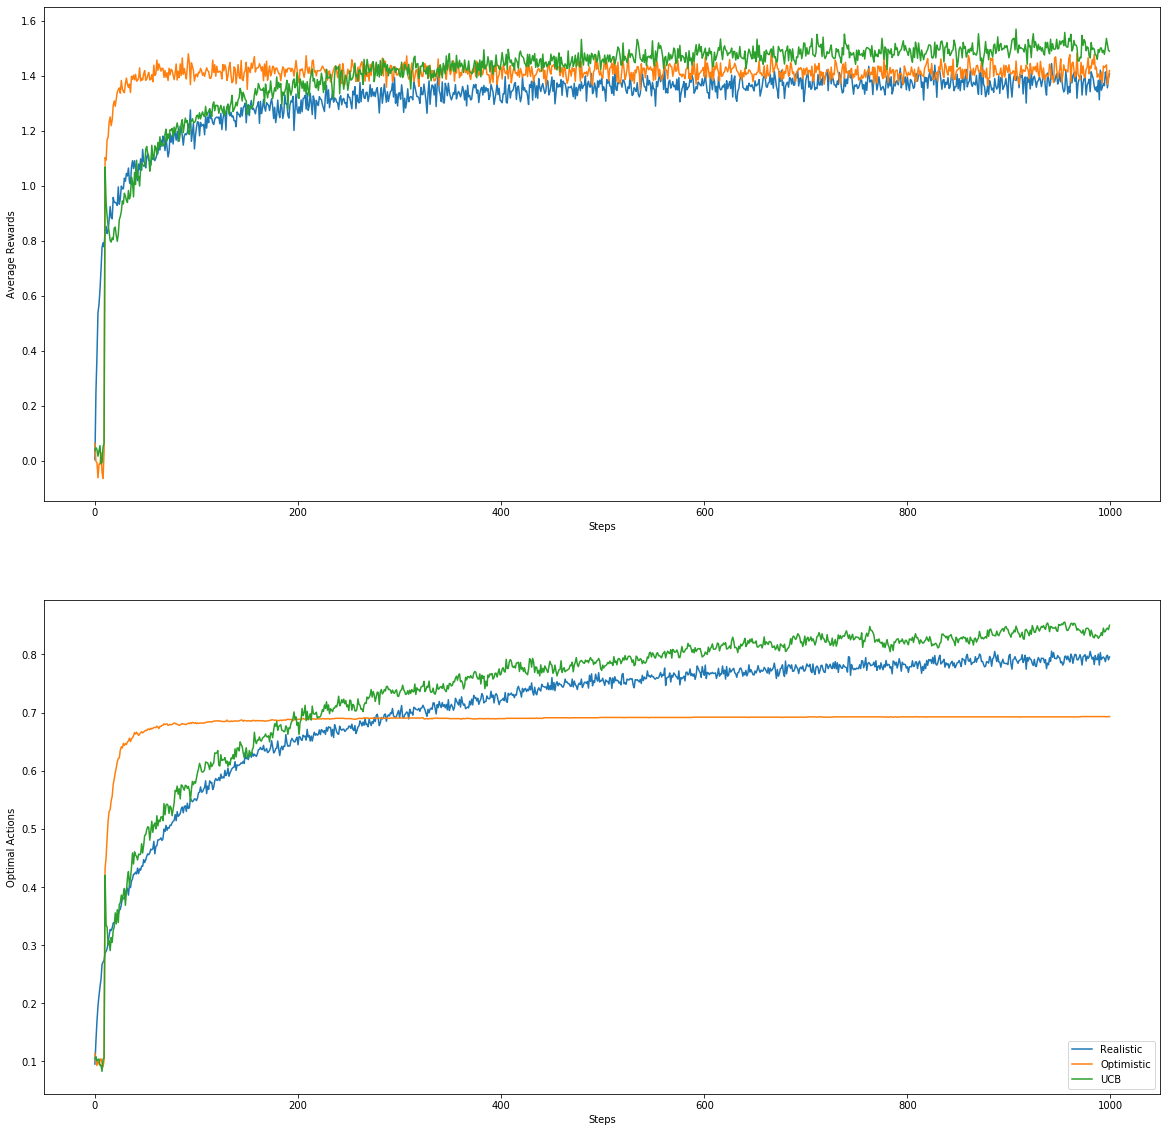

In [146]:
Q4_a()

In [147]:
"""
UCB compared with epsilon greedy in realistic and optimistic settings
for a non-stationary distribution
"""
def Q4_b(runs=2000, steps=10000):
    plt.figure(figsize=(20, 10))
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
    
    # Optimistic Greedy
    epsilon = 0
    epsilons = [epsilon]
    for epsilon in epsilons:
        rewards = np.zeros((runs, steps))
        best_actions = np.zeros((runs, steps))
        
        for run in range(runs):
            trial = multiArmedBandit(mode=2)

            for step in range(steps):
                action = trial.epsilon_greedy_action(epsilon)
                reward = trial.bandits[action].get_reward()
                trial.bandits[action].update_Q_value_constant_step(reward, alpha=0.1)
                rewards[run, step] = reward

                trial.add_noise()
                                
                if action==trial.get_best_action():
                    best_actions[run, step] = 1

        avg_rewards = rewards.mean(axis=0)
        avg_actions = best_actions.mean(axis=0)
        ax[0].plot(range(10000), avg_rewards, label='Optimitic')
        ax[1].plot(range(10000), avg_actions, label='Optimistic')

    # Realistic Greedy
    epsilon = 0.1
    epsilons = [epsilon]
    for epsilon in epsilons:
        rewards = np.zeros((runs, steps))
        best_actions = np.zeros((runs, steps))
        
        for run in range(runs):
            trial = multiArmedBandit(mode=1)
    
            for step in range(steps):
                action = trial.epsilon_greedy_action(epsilon)
                reward = trial.bandits[action].get_reward()
                trial.bandits[action].update_Q_value_constant_step(reward, alpha=0.1)
                rewards[run, step] = reward
                
                trial.add_noise()
                
                if action==trial.get_best_action():
                    best_actions[run, step] = 1
                    
        avg_rewards = rewards.mean(axis=0)
        avg_actions = best_actions.mean(axis=0)
        ax[0].plot(range(10000), avg_rewards, label='Realistic')
        ax[1].plot(range(10000), avg_actions, label='Realistic')
        #plt.legend(['epsilon: '+str(epsilon)])
    
    # UCB
    rewards = np.zeros((runs, steps))
    best_actions = np.zeros((runs, steps))
    for run in range(runs):
        trial = multiArmedBandit(mode=1)

        for step in range(steps):
            action = trial.UCB_action(confidence=2, steps=step)
            reward = trial.bandits[action].get_reward()
            trial.bandits[action].update_Q_value_constant_step(reward, alpha=0.1)
            rewards[run, step] = reward
            
            trial.add_noise()
            
            if action==trial.get_best_action():
                best_actions[run, step] = 1

    avg_rewards = rewards.mean(axis=0)
    avg_actions = best_actions.mean(axis=0)
    ax[0].plot(range(10000), avg_rewards, label='UCB')
    ax[1].plot(range(10000), avg_actions, label='UCB')
    #plt.legend(['epsilon: '+str(epsilon)])
    ax[0].set(xlabel='Steps')
    ax[0].set(ylabel='Average Rewards')
    ax[1].set(xlabel='Steps')
    ax[1].set(ylabel='Optimal Actions')
    plt.legend(loc='lower right')
    plt.show()

<Figure size 1440x720 with 0 Axes>

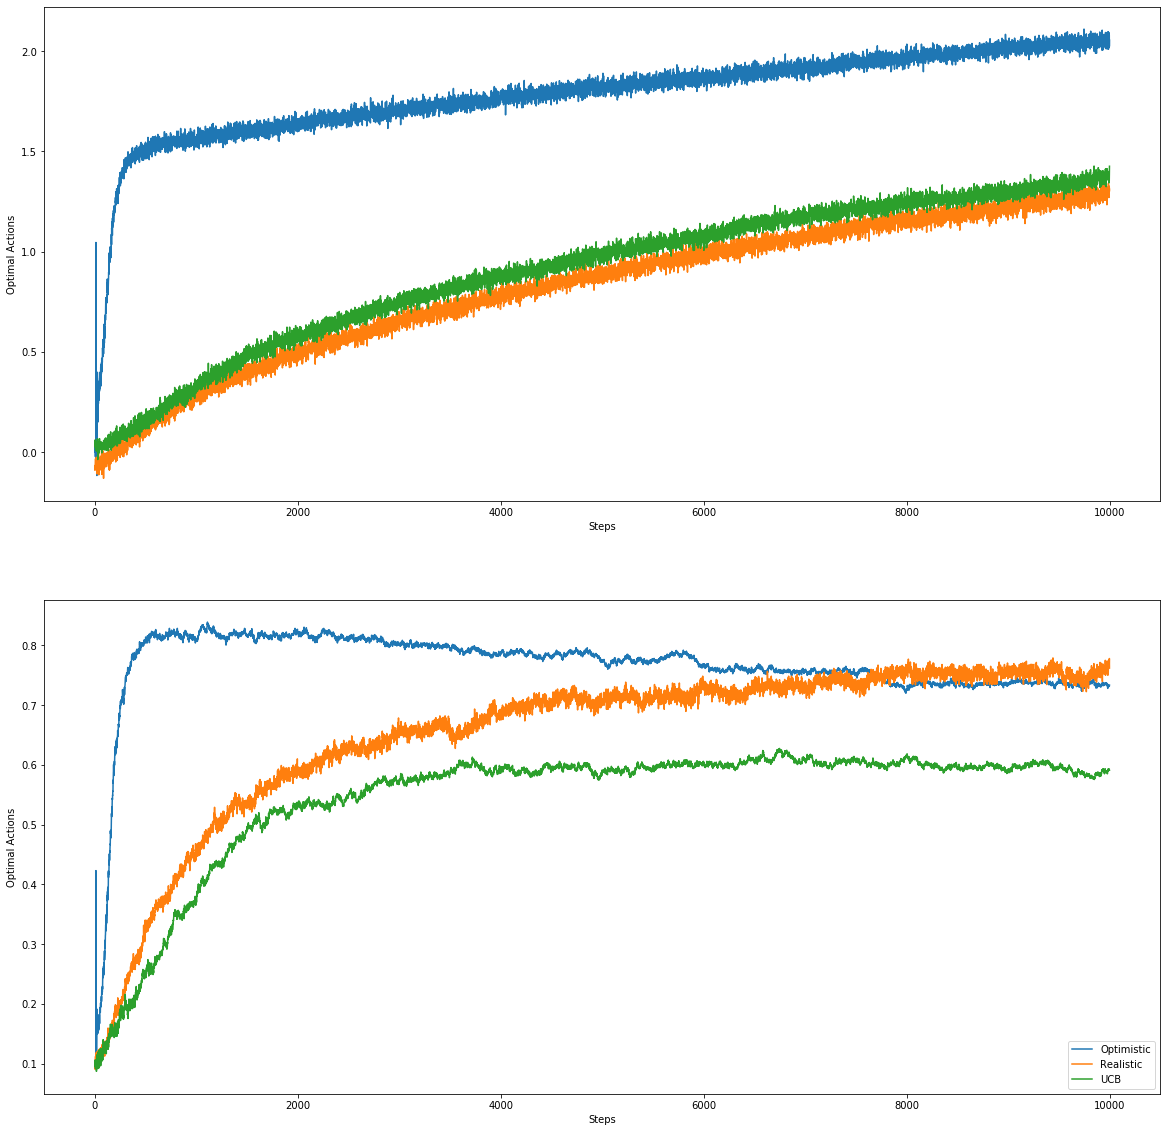

In [148]:
Q4_b()